In [214]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import pandas as pd

from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models import oceandrift

## Run an opendrift simulation using the velocity fields in the cmems files:
- Run one simulation for each of the individual velocity types in the cmems file plus an additional simulation using the original file as is. 
- I needed to modify the original files to add consistant time encoding and to make the time dimension unlimited. It's possible that making the time dimension unlimited isn't strictly necessary, but consistant time encoding is definitely required by opendrift.
- I saved new data files for each of the different velocity types (files containing just the velocity due to Stokes drift, another with just the velocity due to tides, etc)
- The start date/positions used were the same for each simulation and were chosen to match a sample observed drifter file

In [215]:
def run_opendrift(ocean_files, outdir, data_type, start_lon, start_lat, 
                  start_time=None, num_particles=10):
    
    logfile = os.path.join(outdir, "logfile_" + data_type + ".txt")
    outname = os.path.join(outdir, 'simulated-output_' + data_type + '.nc')
    
    ocean_variable_mapping = {'vsdx': 'sea_surface_wave_stokes_drift_x_velocity',
                              'vsdy': 'sea_surface_wave_stokes_drift_y_velocity'}

    # create the simulation object and ocean reader
    o = oceandrift.OceanDrift(loglevel=20, logfile=logfile, seed=None)
    reader_ocean = reader_netCDF_CF_generic.Reader(ocean_files, standard_name_mapping=ocean_variable_mapping)
    
    if start_time is None:
        start_time = reader_ocean.start_time
    
    # add the ocean data reader and seeded elements (radius in meters)
    o.add_reader([reader_ocean])
    o.seed_elements(lon=start_lon, lat=start_lat, number=1, radius=1000, time=start_time)  # lon=-52.5, lat=48.5

    # The output will likely be different that what we would've gotten with the dwt because
    # I didn't set any of the following when running the simulations:
    #o.max_speed = max_speed # back to reasonable max speed
    #o.set_config('drift:advection_scheme','runge-kutta4')
    #o.set_config('general:coastline_action','previous')
    #o.set_config('seed:ocean_only', False)
    #o.set_config('drift:current_uncertainty', current_uncertainty)
    
    print('\nPreparing to run the simulation')
    o.run(
        end_time=reader_ocean.end_time, 
        time_step=600,
        time_step_output=3600,
        outfile=outname,
        export_variables=['lon', 'lat']
    )
    print('Simulation complete. Output saved in:\n' + str(outname))

In [18]:
outdir = "C:/Users/HoldenJe/Drift/projects/stokes_drift/output/match_to_drifter/"
indir = "C:/Users/HoldenJe/Drift/projects/stokes_drift/input_data/CMEMS/"

data_types = ['stokes_only', 'tides_only', 'model_only', 'total_vars', 'all_vars']

for data_type in data_types:
    ocean_files = glob.glob(os.path.join(indir, data_type, "SMOC*.nc"))
    ocean_files.sort()
    
    run_opendrift(ocean_files, outdir, data_type, -49.11514999999997, 47.00027, 
                  datetime(2021, 12, 6, 9, 41, 0), num_particles=1)


Preparing to run the simulation
Simulation complete. Output saved in:
C:/Users/HoldenJe/Drift/projects/stokes_drift/output/match_to_drifter/simulated-output_stokes_only.nc

Preparing to run the simulation
Simulation complete. Output saved in:
C:/Users/HoldenJe/Drift/projects/stokes_drift/output/match_to_drifter/simulated-output_tides_only.nc

Preparing to run the simulation
Simulation complete. Output saved in:
C:/Users/HoldenJe/Drift/projects/stokes_drift/output/match_to_drifter/simulated-output_model_only.nc

Preparing to run the simulation
Simulation complete. Output saved in:
C:/Users/HoldenJe/Drift/projects/stokes_drift/output/match_to_drifter/simulated-output_total_vars.nc

Preparing to run the simulation
Simulation complete. Output saved in:
C:/Users/HoldenJe/Drift/projects/stokes_drift/output/match_to_drifter/simulated-output_all_vars.nc


## Plot the output

In [216]:
def set_up_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax


def plot_modelled_tracks(ax, ds, color='blue', bbox=None, lab='_no_label_'):    
    
    if bbox:
        ax.set_extent(bbox, crs=crs.PlateCarree())
    
    lons = ds.lon.values
    lats = ds.lat.values
    
    # If obs, convert to a list of lists for convenience
    if len(lons) == len(lons.flatten()):
        lons = [ds.lon.values.flatten()]
        lats = [ds.lat.values.flatten()]
    
    # Plot each trajectory:
    for traj in range(0, len(lons)):
        uselab = [lab if traj == 0 else '_no_label_'][0]
        ax.plot(lons[traj], lats[traj], '-', color=color, transform=crs.PlateCarree(), zorder=10, label=uselab)
        if len(lons[traj]) < 100:
            ax.plot(lons[traj], lats[traj], '.', color=color, transform=crs.PlateCarree(), zorder=10)
        #ax.text(lons[traj][-1], lats[traj][-1], ('  ' + uselab), 
        #        ha='left', va='bottom', size=12, color=color)
    
    plt.legend(fontsize=14)
    return ax


def get_common_time(ds_list):
    time_mins = [ds.time.values[0] for ds in ds_list]
    time_maxs = [ds.time.values[-1] for ds in ds_list]
    timemin = max(time_mins)
    timemax = min(time_maxs)
    rounded_timemin = timemin.astype('datetime64[m]')
    rounded_timemax = timemax.astype('datetime64[m]')
    return rounded_timemin, rounded_timemax


def get_adjusted_datasets(ds_list, mintime, maxtime):    
    cropped_traj = []
    for traj in ds_list:
        traj_sel = traj.where(traj['time'] >= mintime, drop=True)
        traj_sel = traj_sel.where(traj_sel['time'] <= maxtime, drop=True)
        cropped_traj.append(traj_sel)
    return cropped_traj


def determine_plot_extent_bbox(traj_outputs, buff_val=None):
    if buff_val is None:
        return None
    bbox = {'minlon': [], 'maxlon': [], 'minlat': [], 'maxlat': []}
    for traj in traj_outputs:  
        lons = traj.lon.values.flatten()
        lats = traj.lat.values.flatten()
        bbox['minlon'] = np.nanmin([bbox['minlon'], np.nanmin(lons)])
        bbox['maxlon'] = np.nanmax([bbox['maxlon'], np.nanmax(lons)])
        bbox['minlat'] = np.nanmin([bbox['minlat'], np.nanmin(lats)])
        bbox['maxlat'] = np.nanmax([bbox['maxlat'], np.nanmax(lats)])
    return [
        bbox['minlon'] - (bbox['maxlon'] - bbox['minlon']) * buff_val,
        bbox['maxlon'] + (bbox['maxlon'] - bbox['minlon']) * buff_val,
        bbox['minlat'] - (bbox['maxlat'] - bbox['minlat']) * buff_val,
        bbox['maxlat'] + (bbox['maxlat'] - bbox['minlat']) * buff_val
    ]


def create_tracks_plot(traj_outputs, colors, labs, mintime, maxtime, buff_val=None):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree())
    ax = set_up_plot(ax)

    # Only keep data within the mintime, maxtime range
    traj_outputs = get_adjusted_datasets(traj_outputs, mintime, maxtime)
    
    # find the common extents of the plot for all tracks
    bbox = determine_plot_extent_bbox(traj_outputs, buff_val=buff_val)

    for traj, col, lab in zip(traj_outputs, colors, labs):
        ax = plot_modelled_tracks(ax, traj, color=col, bbox=bbox, lab=lab)

    stime = str(mintime)[:10]
    etime = str(maxtime)[:10]
    datestr = '-'.join([stime.replace('-', ''), etime.replace('-', '')])
    plt.title(datestr.replace('-', ' - '), fontsize=16)
    savename = 'tracks_' + datestr.replace(' ', '') + '.png'
    plt.savefig(os.path.join(outdir, savename), dpi=600)

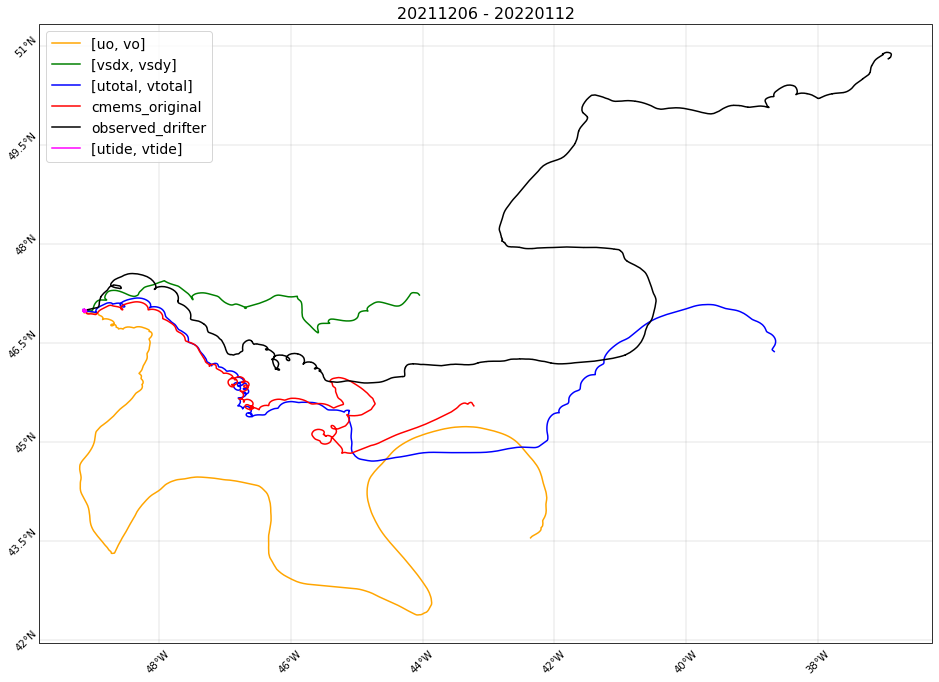

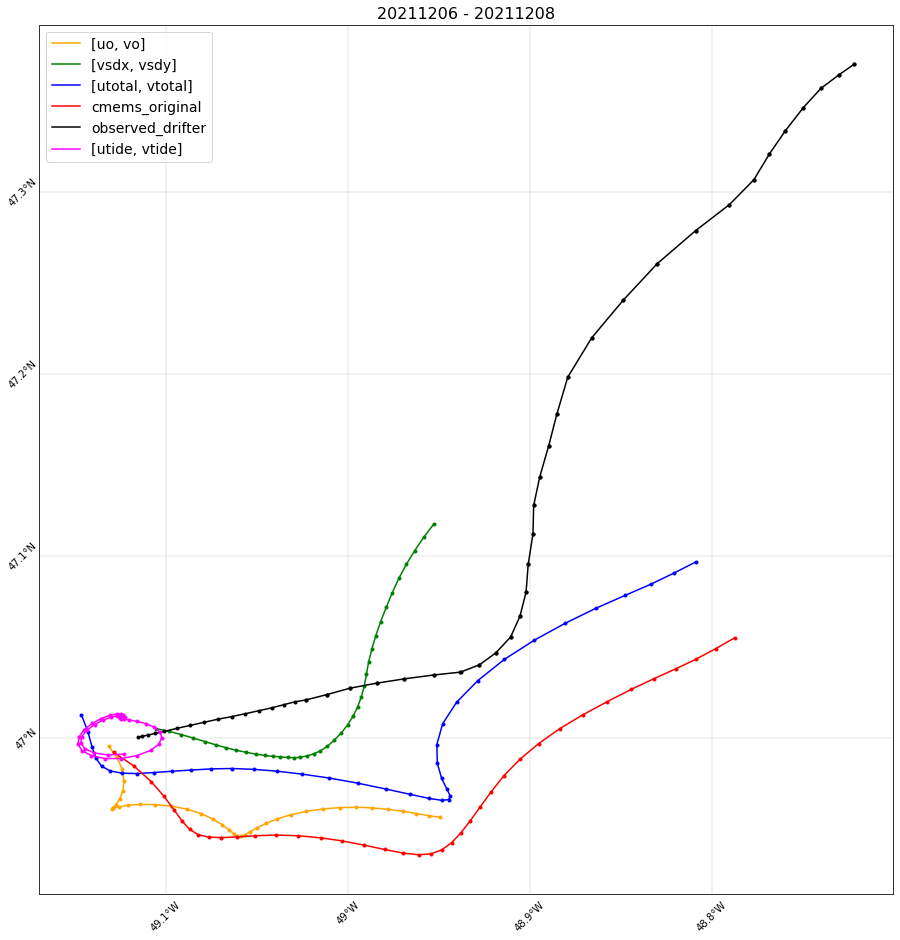

In [218]:
outdir = "C:/Users/HoldenJe/Drift\projects/stokes_drift/output/match_to_drifter/"
stokes_output = xr.load_dataset(os.path.join(outdir, "simulated-output_stokes_only.nc"))
tides_output = xr.load_dataset(os.path.join(outdir, "simulated-output_tides_only.nc"))
model_output = xr.load_dataset(os.path.join(outdir, "simulated-output_model_only.nc"))
total_output = xr.load_dataset(os.path.join(outdir, "simulated-output_total_vars.nc"))
all_output = xr.load_dataset(os.path.join(outdir, "simulated-output_all_vars.nc"))

obsdir = "C:/Users/HoldenJe/Drift/projects/stokes_drift/input_data/obs_drifters/netcdf/netcdf_2023-01-17/"
obs = xr.load_dataset(os.path.join(obsdir, 'SPOT1017D2021120609.nc'))
obs = obs.rename({'LONGITUDE': 'lon', 'LATITUDE': 'lat', 'TIME': 'time'})

traj_outputs = [model_output, stokes_output, total_output, all_output, obs, tides_output]
colors = ['orange', 'green', 'blue', 'red', 'black', 'magenta']
labs = ['[uo, vo]', '[vsdx, vsdy]', '[utotal, vtotal]', 'cmems_original', 'observed_drifter', '[utide, vtide]']

mintime, maxtime = get_common_time(traj_outputs)

# looking at the full time period
create_tracks_plot(traj_outputs, colors, labs, mintime, maxtime)

# looking at the first two days
create_tracks_plot(traj_outputs, colors, labs, mintime, np.datetime64('2021-12-08'))

### some misc notes: